# Classification and Product Recommendation System

In this notebook, I have classified the positive and negative reviews by performing sentiment analysis on review text. The text is preprocessed in a separate notebook and polarity of the review text is alos obtained using Textblob in the previous notebook. The techniques used are Logistic Regression with countvectorizer, Logistic with TFIDF vectorizer, Multinomial with Tfidf, Linear SVC with Countvetorizer and the best model is found using the recall and precision as we are dealing with a imbalanced class. I have also classifed the using a simple BiLSTM network in separate notebook and have linked at the end of this notebook.

The fisrt step is to mount the drive to colab and import the necessary libraries.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline



from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.stem.snowball import EnglishStemmer
from nltk.corpus import stopwords
import regex as re
from tabulate import tabulate


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC
from pylab import rcParams

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, confusion_matrix,  plot_roc_curve, roc_curve, auc
import nltk
nltk.download('wordnet')
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# Read the csv

In [45]:
#Read the preprocessed csv file
df = pd.read_csv('gdrive/My Drive/Capstone_project/reviews_preprocessed.csv',usecols = ['reviewerID','title','ratings','clean_text','reviewcomb','polarity'])

In [46]:
df.head()

,reviewerID,ratings,title,reviewcomb,clean_text,polarity
0,A11LNPG39A2ZV4,5.0,"Marvis Jasmin Mint Toothpaste, 3.8 oz","I've been using&nbsp;<a data-hook=""product-lin...",use marvi classic strong mint toothpast year r...,0.309612
1,A1VUN4JU731CBH,5.0,"Marvis Jasmin Mint Toothpaste, 3.8 oz",I had seen the Marvis toothpastes before and a...,seen marvi toothpast alway wonder world anyon ...,0.234115
2,A2CBVSJ1OV2Q4S,5.0,"Marvis Jasmin Mint Toothpaste, 3.8 oz",I buy the Jasmine Marvis Toothpaste because it...,buy jasmin marvi toothpast uniqu floral scent ...,0.301515
3,A34XM0ECYBB4DH,5.0,"Marvis Jasmin Mint Toothpaste, 3.8 oz",This toothpaste is the best I've ever tried. ...,toothpast best ever tri tast realli good light...,0.694000
4,A2PMRY7ADA8WJ2,5.0,"Marvis Jasmin Mint Toothpaste, 3.8 oz",i didn't know what i was missing until i tried...,know miss tri toothpast make other tast artifi...,0.187202


In [47]:
df.shape

(464829, 6)

Some of the empty strings are read as null values while pandas were reading the preprocessed csvs. Therefore will drop the Nan values before modelling.

In [48]:
#drop nans
df.isnull().sum()

reviewerID     0
ratings        0
title          0
reviewcomb     0
clean_text    14
polarity       0
dtype: int64

In [49]:
df.dropna(inplace=True)

In [50]:
df.isnull().sum()

reviewerID    0
ratings       0
title         0
reviewcomb    0
clean_text    0
polarity      0
dtype: int64

In [9]:
df.head()

,reviewerID,ratings,title,clean_text,polarity
0,A11LNPG39A2ZV4,5.0,"Marvis Jasmin Mint Toothpaste, 3.8 oz",use marvi classic strong mint toothpast year r...,0.309612
1,A1VUN4JU731CBH,5.0,"Marvis Jasmin Mint Toothpaste, 3.8 oz",seen marvi toothpast alway wonder world anyon ...,0.234115
2,A2CBVSJ1OV2Q4S,5.0,"Marvis Jasmin Mint Toothpaste, 3.8 oz",buy jasmin marvi toothpast uniqu floral scent ...,0.301515
3,A34XM0ECYBB4DH,5.0,"Marvis Jasmin Mint Toothpaste, 3.8 oz",toothpast best ever tri tast realli good light...,0.694000
4,A2PMRY7ADA8WJ2,5.0,"Marvis Jasmin Mint Toothpaste, 3.8 oz",know miss tri toothpast make other tast artifi...,0.187202


While checking the proportion of rating classes we could see that it is a highly imbalanced dataset. Therefore I will combine the rating class below 3 as Negative reviews and rating class above 3 as Positive reviews. 

In [51]:
df['ratings'].value_counts(normalize=True)

5.0    0.647159
4.0    0.126229
1.0    0.093891
3.0    0.077601
2.0    0.055121
Name: ratings, dtype: float64

In [52]:
df_original = df.copy()

# Sentiment Rating

In [53]:
#Defining positive and negative sentiment
df['Sentiment_rating']=np.where(df.ratings>3,1,0)
#Ignore 3 ratings
df = df[df.ratings !=3]



In [54]:
#Baseline model
df['Sentiment_rating'].value_counts(normalize=True)

1    0.838452
0    0.161548
Name: Sentiment_rating, dtype: float64

In [55]:
df

,reviewerID,ratings,title,reviewcomb,clean_text,polarity,Sentiment_rating
0,A11LNPG39A2ZV4,5.0,"Marvis Jasmin Mint Toothpaste, 3.8 oz","I've been using&nbsp;<a data-hook=""product-lin...",use marvi classic strong mint toothpast year r...,0.309612,1
1,A1VUN4JU731CBH,5.0,"Marvis Jasmin Mint Toothpaste, 3.8 oz",I had seen the Marvis toothpastes before and a...,seen marvi toothpast alway wonder world anyon ...,0.234115,1
2,A2CBVSJ1OV2Q4S,5.0,"Marvis Jasmin Mint Toothpaste, 3.8 oz",I buy the Jasmine Marvis Toothpaste because it...,buy jasmin marvi toothpast uniqu floral scent ...,0.301515,1
3,A34XM0ECYBB4DH,5.0,"Marvis Jasmin Mint Toothpaste, 3.8 oz",This toothpaste is the best I've ever tried. ...,toothpast best ever tri tast realli good light...,0.694000,1
4,A2PMRY7ADA8WJ2,5.0,"Marvis Jasmin Mint Toothpaste, 3.8 oz",i didn't know what i was missing until i tried...,know miss tri toothpast make other tast artifi...,0.187202,1
...,...,...,...,...,...,...,...
464823,A3IRO9Y2W7DGXU,5.0,"CND Shellac, Brick Knit",My wife bought it and loves it. She says paint...,wife bought love say paint fade last longer ev...,0.666667,1
464824,A2HPJMRRTYJ2M9,5.0,"CND Shellac, Brick Knit",CND Shellac Power Polish is wonderful! This co...,cnd shellac power polish wonder color brick kn...,0.926667,1
464825,A37M9GZV5PMABX,2.0,"CND Shellac, Brick Knit","the colour is too dark, Two Stars",colour dark two star,-0.150000,0
464827,A2VVJW6PY48A9M,5.0,"CND Shellac, Brick Knit","Great product, PERFECT SHADE!! :) Love the de...",great product perfect shade love deep red color,0.466667,1


# Modelling

## Binary classification

Lets first define the X and y variables. Here I want to build a classifier on reviews text. As already mentioned the reviews were already cleaned, tokenized and stemmed using porter stemmer in a separate notebook. Therefore will use pipeline to vectorise the text directly and then will tune the models with different paramaters.

### Countvectorizer with Logistic Regression

Count Vectorizer is a way to convert a given set of strings into a frequency representation. In my first classifier am using Countvectorizer with Logistic regression and have analyse the top 20 positive and negatuve words that were helpful in predicting the two classes.

In [56]:
#Define function to evaluate model
def eval(model):
  metrics ={}
  train_pred = model.predict(X_train)
  test_pred = model.predict(X_test)
  roc_auc_train = roc_auc_score(y_train, train_pred)
  roc_auc_test = roc_auc_score(y_test, test_pred)
  tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()
  recall = tp/(tp + fn) #sensitivity
  precision = tp/(tp+fp)
  specificity = tn/(tn + fp)
  accuracy = (tn + tp)/(tn + tp + fn + fp)
  fpr = fp/(fp+tn)
  
  
  metrics['roc_auc_train'] = roc_auc_train
  metrics['roc_auc_test'] = roc_auc_test
  metrics['accuracy'] = accuracy
  metrics['precision'] = precision
  metrics['recall'] = recall
  metrics['specificity'] = specificity
  metrics['FalsePos'] = fp
  metrics['TruePos'] = tp
  metrics['FalseNeg'] = fn
  metrics['TrueNeg'] = tn
  metrics['FPR'] = fpr
  # metrics['logloss'] = log_loss(y_test, test_pred, eps=1e-15)
  return (metrics)
  

In [ ]:
#Define the dependent and independent variables
X = df['clean_text']
y = df['Sentiment_rating']

In [ ]:
X_train, X_test,y_train, y_test = train_test_split(X,y,stratify =y,test_size=0.2, random_state=0)

In [ ]:
pipe1 = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('lr', LogisticRegression(max_iter = 1000)),
])

In [ ]:
pipe_params1 = {
    'cvec__max_features': [5000],
    'cvec__min_df': [1,2],
    'cvec__max_df': [0.9,0.95],
    'cvec__ngram_range': [(1,1),(1,2)],
}

In [ ]:
gs1 = GridSearchCV(pipe1, 
                   param_grid=pipe_params1, scoring='recall',
                   cv=5)

In [ ]:
gs1.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [ ]:
gs1.best_params_

{'cvec__max_features': 5000, 'cvec__ngram_range': (1, 2)}

In [ ]:
gs_model1 = gs1.best_estimator_

In [ ]:
print(gs_model1.score(X_train,y_train))
print(gs_model1.score(X_test,y_test))

0.9353345228515785
0.929865071312785


In [ ]:
metrics_lrcv = eval(gs_model1)
print(metrics_lrcv)

{'roc_auc_train': 0.843019433830826, 'roc_auc_test': 0.8312763323300447, 'accuracy': 0.929865071312785, 'precision': 0.9416157228657228, 'recall': 0.976925002781796, 'specificity': 0.6856276618782935, 'FalsePos': 4355, 'TruePos': 70237, 'FalseNeg': 1659, 'TrueNeg': 9498, 'FPR': 0.3143723381217065}


In [ ]:
y_pred = gs_model1.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.69      0.76     13853
           1       0.94      0.98      0.96     71896

    accuracy                           0.93     85749
   macro avg       0.90      0.83      0.86     85749
weighted avg       0.93      0.93      0.93     85749



In [ ]:
coef_names = gs1.best_estimator_.named_steps.cvec.get_feature_names()

In [ ]:
coef_df = pd.DataFrame({'coefficients': coef_names, 'values' : gs1.best_estimator_.steps[1][1].coef_[0]})

In [ ]:
coef_df.sort_values(by='values',ascending=False, inplace = True)

In [ ]:
#Top 20 positive words
coef_df.head(20)

,coefficients,values
4940,worth everi,2.935364
1364,far good,2.851502
4088,sooner,2.642332
1093,dri minut,2.591277
2927,noth compar,2.473892
2280,let sit,2.400478
2031,high recommend,2.367600
2073,huge differ,2.315711
345,better expect,2.289854
2928,noth els,2.289124


In [ ]:
#top 20 negative words using countvectorizer
coef_df.tail(20)

,coefficients,values
3618,return,-1.928019
212,aw,-1.930706
4560,unhappi,-1.981131
2183,juic beauti,-2.004747
3790,shame,-2.025593
4721,useless,-2.072251
4164,stay away,-2.122358
1032,disappoint,-2.143216
4936,worst,-2.185822
4484,trash,-2.228142


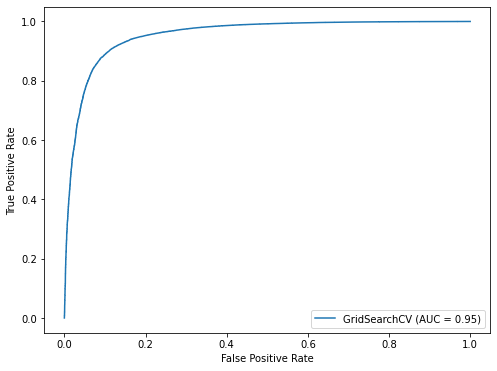

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
lr_cvec = plot_roc_curve(gs1, X_test, y_test, ax=ax)

Some of the ngrams doesn't make any sense such as 'dri minut' , 'noth compar', 'let sit' , 'noth els' and 'juic beauti'. Therfore will use TFIDF in the next section which is better than countvectorizer.

### Tfidf with Logistic Regression

TF-IDF is better than Count Vectorizers because it not only focuses on the frequency of words present in the corpus but also provides the importance of the words

In [15]:
X = df['clean_text']
y = df['Sentiment_rating']

In [16]:
X.shape,y.shape

((428745,), (428745,))

In [17]:
X_train, X_test,y_train, y_test = train_test_split(X,y,stratify =y,test_size=0.2, random_state=0)

In [18]:
X_train.shape, y_train.shape

((342996,), (342996,))

In [19]:
pipe2 = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('lr', LogisticRegression(max_iter = 1000)),
])

In [20]:
pipe_params2 = {
    'tvec__max_features': [1000,5000],
#     'tvec__min_df': [1,2, 3],
#     'tvec__max_df': [0.7,0.8, 0.85, 0.90],
    'tvec__ngram_range': [(1,1),(1, 2)],
    # 'lr__max_iter': [100,300]
}

In [21]:
gs2 = GridSearchCV(pipe2, 
                   param_grid=pipe_params2, 
                   cv=5)


In [22]:
gs2.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [23]:
gs2.best_params_

{'tvec__max_features': 5000, 'tvec__ngram_range': (1, 2)}

In [24]:
gs_model2 = gs2.best_estimator_

In [25]:
print(gs_model2.score(X_train,y_train))
print(gs_model2.score(X_test,y_test))

0.9369059697489184
0.9334336260481172


In [28]:
metrics_lrtf = eval(gs_model2)
print(metrics_lrtf)

{'roc_auc_train': 0.8488448010058495, 'roc_auc_test': 0.841213597962282, 'accuracy': 0.9334336260481172, 'precision': 0.9450391328904548, 'recall': 0.9774535440080115, 'specificity': 0.7049736519165524, 'FalsePos': 4087, 'TruePos': 70275, 'FalseNeg': 1621, 'TrueNeg': 9766, 'FPR': 0.29502634808344763}


In [29]:
y_pred = gs_model2.predict(X_test)

In [30]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.70      0.77     13853
           1       0.95      0.98      0.96     71896

    accuracy                           0.93     85749
   macro avg       0.90      0.84      0.87     85749
weighted avg       0.93      0.93      0.93     85749



In [31]:
coef_names = gs2.best_estimator_.named_steps.tvec.get_feature_names()

In [32]:
coef_df = pd.DataFrame({'coefficients': coef_names, 'values' : gs2.best_estimator_.steps[1][1].coef_[0]})

In [33]:
coef_df.sort_values(by='values',ascending=False, inplace = True)

In [34]:
coef_df.head(20)

,coefficients,values
2513,love,13.413580
296,best,12.909326
1694,great,11.856847
101,amaz,9.855198
3079,perfect,9.672611
1247,excel,9.071576
2031,high recommend,8.684857
216,awesom,8.050686
2882,nice,7.072942
1381,favorit,6.967485


In [35]:
coef_df.tail(20)

,coefficients,values
1045,dissapoint,-4.849821
1012,didnt,-4.900981
3562,refund,-5.049060
2918,nope,-5.235527
3162,poor,-5.595074
4935,wors,-5.659150
4783,wast money,-5.670086
4721,useless,-5.828539
480,broke,-6.015880
2713,meh,-6.109452


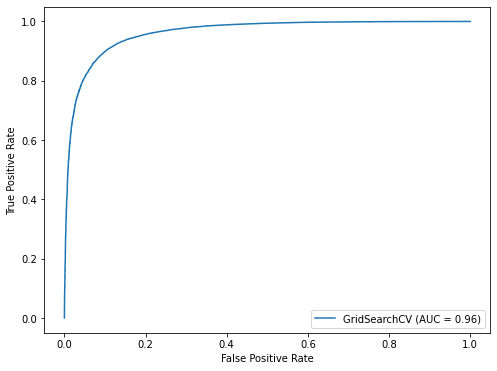

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))
lr_tf = plot_roc_curve(gs2, X_test, y_test, ax=ax)

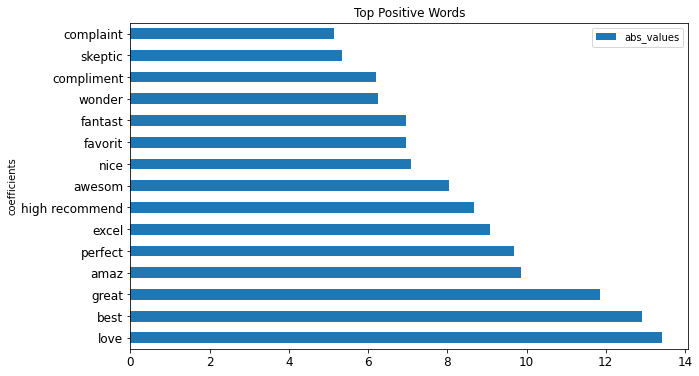

In [ ]:
coef_df['abs_values'] = abs(coef_df['values'])
coef_df.head(15).plot(kind = 'barh', x = 'coefficients', y = 'abs_values', 
                      fontsize = 12, figsize = (10, 6), title = 'Top Positive Words')


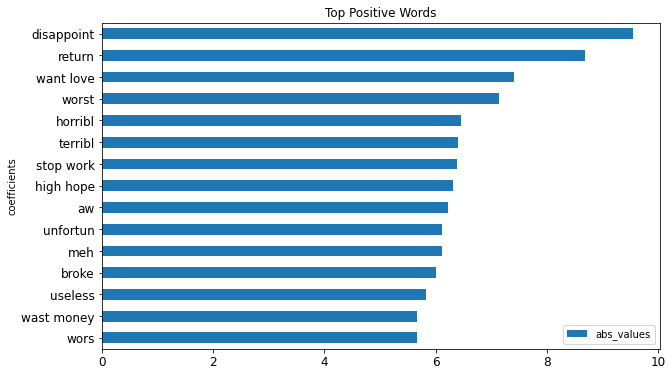

In [ ]:
coef_df['abs_values'] = abs(coef_df['values'])
coef_df.tail(15).plot(kind = 'barh', x = 'coefficients', y = 'abs_values', 
                      fontsize = 12, figsize = (10, 6), title = 'Top Negative Words')


In [89]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(data=cm, columns=['predicted neg', 'predicted pos'], index=['actual neg', 'actual pos'])
cm_df

,predicted neg,predicted pos
actual neg,9766,4087
actual pos,1621,70275


### Multinomial Naive Bayes

In [ ]:
X = df['clean_text']
y = df['Sentiment_rating']

In [ ]:
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2,stratify = y, random_state=0)

In [ ]:
pipe3 = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB()),
])

In [ ]:
pipe_params3 = {
    'tvec__max_features': [5000],
#     'tvec__min_df': [1,2, 3],
#     'tvec__max_df': [0.7,0.8, 0.85, 0.90],
    'tvec__ngram_range': [(1,1),(1, 2)],
}

In [ ]:
gs3 = GridSearchCV(pipe3, 
                   param_grid=pipe_params3, 
                   cv=5)

In [ ]:
gs3.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [ ]:
gs3.best_params_

{'tvec__max_features': 5000, 'tvec__ngram_range': (1, 2)}

In [ ]:
gs_model3 = gs3.best_estimator_

In [ ]:
print(gs_model3.score(X_train,y_train))
print(gs_model3.score(X_test,y_test))

0.9074741396401125
0.9056898622724463


In [ ]:
metrics_mnb_tf = eval(gs_model3)
print(metrics_mnb_tf)

{'roc_auc_train': 0.7368212398778096, 'roc_auc_test': 0.7303175126570007, 'accuracy': 0.9056898622724463, 'precision': 0.9066391363642157, 'recall': 0.9894013575164126, 'specificity': 0.47123366779758896, 'FalsePos': 7325, 'TruePos': 71134, 'FalseNeg': 762, 'TrueNeg': 6528, 'FPR': 0.528766332202411}


In [ ]:
y_pred = gs_model3.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.47      0.62     13853
           1       0.91      0.99      0.95     71896

    accuracy                           0.91     85749
   macro avg       0.90      0.73      0.78     85749
weighted avg       0.90      0.91      0.89     85749



In [ ]:
coef_names = gs3.best_estimator_.named_steps.tvec.get_feature_names()

In [ ]:
coef_df = pd.DataFrame({'coefficients': coef_names, 'values' : gs3.best_estimator_.steps[1][1].coef_[0]})

In [ ]:
coef_df.sort_values(by='values',ascending=False, inplace = True)

In [ ]:
coef_df.head(20)

,coefficients,values
4153,star,-4.326892
2513,love,-4.466319
3244,product,-4.561493
1694,great,-4.574536
1804,hair,-4.681793
4585,use,-4.727298
3897,skin,-5.094667
1621,good,-5.128473
4895,work,-5.164895
3990,smell,-5.230588


In [ ]:
coef_df.tail(20)

,coefficients,values
2028,high hope,-11.423135
1377,faulti,-11.551070
1052,doesnt work,-11.603450
4390,threw away,-11.618443
2929,noth hair,-11.685592
3149,polici,-11.749319
9,absolut noth,-11.785875
1033,disappoint disappoint,-11.852456
1351,fake product,-11.872795
3621,return product,-11.881444


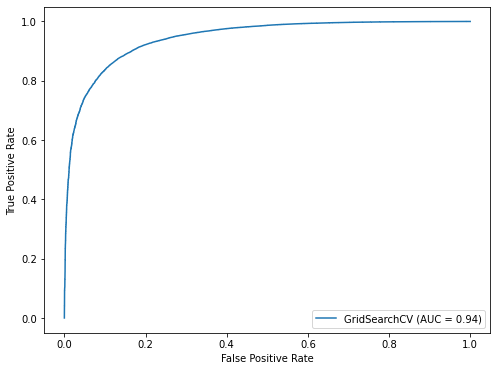

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
mnb_tf = plot_roc_curve(gs3, X_test, y_test, ax=ax)

### Linear SVC

In [ ]:
X = df['clean_text']
y = df['Sentiment_rating']

In [ ]:
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2,stratify = y,random_state=0)

In [ ]:
pipe4 = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')),
    ('svc', LinearSVC(dual=False)),
])

In [ ]:
pipe_params4 = {
    'cvec__max_features': [5000],
    'cvec__min_df': [1,2],
    'cvec__max_df': [0.5,0.95],
    'cvec__ngram_range': [(1,1),(1,2)],
}

In [ ]:
gs4 = GridSearchCV(pipe4, 
                   param_grid=pipe_params4, 
                   cv=5)

In [ ]:
gs4.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [ ]:
gs4.best_params_

{'cvec__max_df': 0.5,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

In [ ]:
gs_model4 = gs4.best_estimator_

In [ ]:
print(gs_model4.score(X_train,y_train))
print(gs_model4.score(X_test,y_test))

0.9328330359537721
0.9280108222836418


In [ ]:
metrics_svc_cv = eval(gs_model4)
print(metrics_svc_cv)

{'roc_auc_train': 0.8326035424554211, 'roc_auc_test': 0.8217786011975831, 'accuracy': 0.9280108222836418, 'precision': 0.9381007612419843, 'recall': 0.9787192611550016, 'specificity': 0.6648379412401646, 'FalsePos': 4643, 'TruePos': 70366, 'FalseNeg': 1530, 'TrueNeg': 9210, 'FPR': 0.3351620587598354}


In [ ]:
y_pred = gs_model4.predict(X_test)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.66      0.75     13853
           1       0.94      0.98      0.96     71896

    accuracy                           0.93     85749
   macro avg       0.90      0.82      0.85     85749
weighted avg       0.93      0.93      0.92     85749



In [ ]:
coef_names = gs4.best_estimator_.named_steps.cvec.get_feature_names()

In [ ]:
coef_df = pd.DataFrame({'coefficients': coef_names, 'values' : gs4.best_estimator_.steps[1][1].coef_[0]})

In [ ]:
coef_df.sort_values(by='values',ascending=False, inplace = True)

In [ ]:
coef_df.head(20)

,coefficients,values
307,best eyelin,1.431557
2284,life saver,1.066033
2140,iredal,1.045075
1092,dri minut,1.031957
2047,holi grail,1.030521
2022,hesit buy,0.981614
1243,exceed expect,0.978745
4940,worth everi,0.972071
2927,noth compar,0.900933
4086,sooner,0.840216


In [ ]:
coef_df.tail(20)

,coefficients,values
1031,disappoint,-0.667344
4162,stay away,-0.678860
4936,worst,-0.679343
4482,trash,-0.679364
2929,noth hair,-0.680008
2183,juic beauti,-0.682123
2918,nope,-0.722262
4185,stop work,-0.735177
4990,yuck,-0.742613
2028,high hope,-0.755820


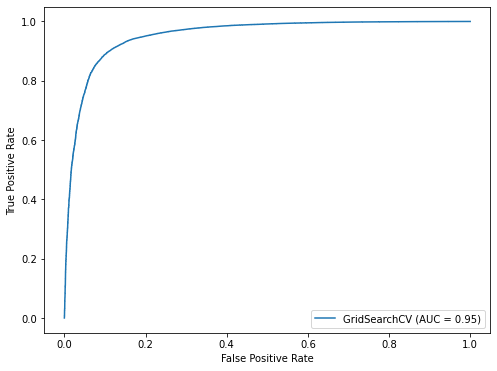

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
svc_cv = plot_roc_curve(gs4, X_test, y_test, ax=ax)

#Model comparison

In [ ]:
scores = [['Logistic Regression_CV', metrics_lrcv['roc_auc_train'], metrics_lrcv['roc_auc_test'], 
           metrics_lrcv['recall'], metrics_lrcv['precision'],metrics_lrcv['specificity'], metrics_lrcv['accuracy'],metrics_lrcv['FPR']],
          ['Logistic Regression_TFIDF', metrics_lrtf['roc_auc_train'], metrics_lrtf['roc_auc_test'], 
           metrics_lrtf['recall'],metrics_lrtf['precision'], metrics_lrtf['specificity'], metrics_lrtf['accuracy'],metrics_lrtf['FPR']],
          ['MultinomialNB_TFIDF', metrics_mnb_tf['roc_auc_train'], metrics_mnb_tf['roc_auc_test'], 
           metrics_mnb_tf['recall'],metrics_mnb_tf['precision'], metrics_mnb_tf['specificity'], metrics_mnb_tf['accuracy'],metrics_mnb_tf['FPR']],
          ['Linear_SVC_CV', metrics_svc_cv['roc_auc_train'], metrics_svc_cv['roc_auc_test'], 
           metrics_svc_cv['recall'],metrics_svc_cv['precision'], metrics_svc_cv['specificity'], metrics_svc_cv['accuracy'],metrics_svc_cv['FPR']]]
          
print(tabulate(scores,headers=["", "Roc Auc Train", "Roc Auc Test", 'Recall','Precision' ,'Specificity', "Accuracy","FPR"])) 

                             Roc Auc Train    Roc Auc Test    Recall    Precision    Specificity    Accuracy       FPR
-------------------------  ---------------  --------------  --------  -----------  -------------  ----------  --------
Logistic Regression_CV            0.843019        0.831276  0.976925     0.941616       0.685628    0.929865  0.314372
Logistic Regression_TFIDF         0.848845        0.841214  0.977454     0.945039       0.704974    0.933434  0.295026
MultinomialNB_TFIDF               0.736821        0.730318  0.989401     0.906639       0.471234    0.90569   0.528766
Linear_SVC_CV                     0.832604        0.821779  0.978719     0.938101       0.664838    0.928011  0.335162


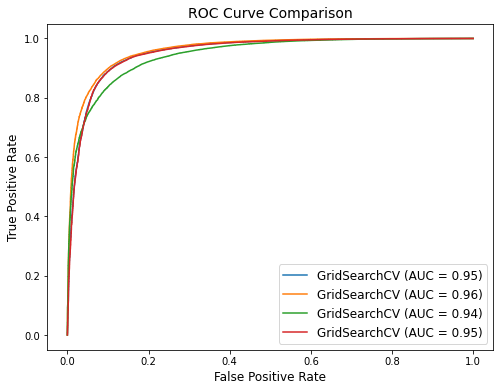

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
lr_cv = plot_roc_curve(gs1, X_test, y_test, ax=ax)
lr_tf = plot_roc_curve(gs2, X_test, y_test, ax=ax)
mnb_tf = plot_roc_curve(gs3, X_test, y_test, ax=ax)
svc_cv = plot_roc_curve(gs4, X_test, y_test, ax=ax)

ax.set_title('ROC Curve Comparison', fontsize=14)
ax.legend(fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_xlabel('False Positive Rate', fontsize=12);

Since I would like to recommend products that have positive sentiments, I would be optimizing the model for low False Positive Rates. Here we want to reduce the Type 1 error and also look for high precision(Positive predicted value). 

# Implementation

In [57]:
X = df['clean_text']
y = df['Sentiment_rating']

In [58]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('lr', LogisticRegression(max_iter = 1000)),
])

In [59]:
pipe_params = {
    'tvec__max_features': [5000],
#     'tvec__min_df': [1,2, 3],
#     'tvec__max_df': [0.7,0.8, 0.85, 0.90],
    'tvec__ngram_range': [(1,1),(1, 2)],
    # 'lr__max_iter': [100,300]
}

In [60]:
gs = GridSearchCV(pipe, 
                   param_grid=pipe_params, 
                   cv=5)


In [61]:
gs.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        no

In [63]:
gs_model = gs.best_estimator_

In [64]:
print(gs_model.score(X,y))


0.9368925585138019


In [65]:
metrics_lr = eval(gs_model)
print(metrics_lr)

{'roc_auc_train': 0.8500256373017955, 'roc_auc_test': 0.8495065040208106, 'accuracy': 0.9369322091219723, 'precision': 0.947815076243332, 'recall': 0.9786636252364527, 'specificity': 0.7203493828051686, 'FalsePos': 3874, 'TruePos': 70362, 'FalseNeg': 1534, 'TrueNeg': 9979, 'FPR': 0.2796506171948314}


In [66]:
pred = gs_model.predict(X)

In [67]:
print(classification_report(y,pred))

              precision    recall  f1-score   support

           0       0.87      0.72      0.79     69263
           1       0.95      0.98      0.96    359482

    accuracy                           0.94    428745
   macro avg       0.91      0.85      0.87    428745
weighted avg       0.93      0.94      0.93    428745



In [72]:
coef_names = gs.best_estimator_.named_steps.tvec.get_feature_names()

In [73]:
coef_df = pd.DataFrame({'coefficients': coef_names, 'values' : gs.best_estimator_.steps[1][1].coef_[0]})

In [74]:
coef_df.sort_values(by='values',ascending=False, inplace = True)

In [75]:
#Top 20 positive words
coef_df.head(20)

,coefficients,values
2499,love,13.400409
294,best,12.690347
1683,great,11.916900
100,amaz,10.152574
3068,perfect,9.854654
1240,excel,9.366459
2021,high recommend,9.226772
215,awesom,8.384757
1351,fantast,7.380968
2872,nice,7.050930


In [76]:
coef_df.tail(20)

,coefficients,values
3683,save money,-5.007846
4765,want like,-5.019280
3553,refund,-5.334764
2909,nope,-5.418640
3152,poor,-5.524930
4784,wast money,-5.662932
4934,wors,-5.810382
473,broke,-6.131377
2703,meh,-6.237780
4723,useless,-6.250421


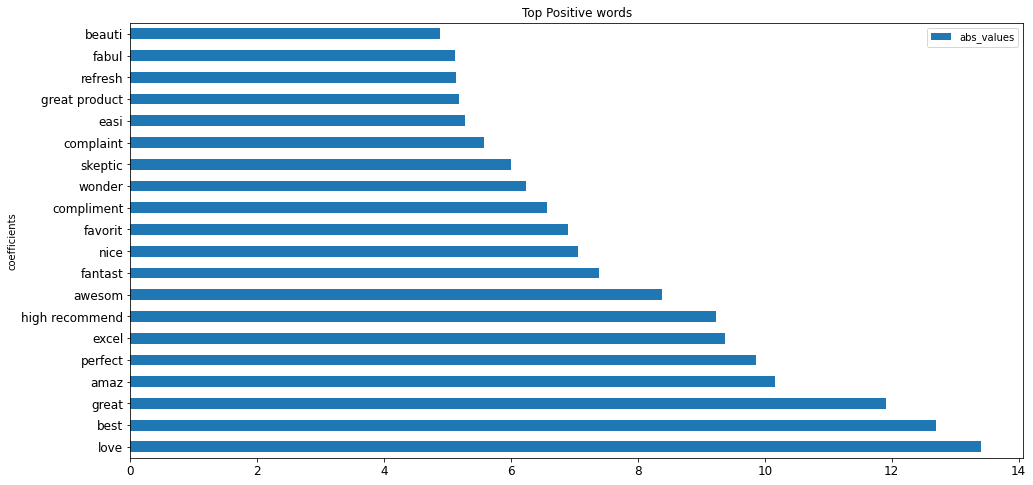

In [ ]:
coef_df['abs_values'] = abs(coef_df['values'])
coef_df.head(20).plot(kind = 'barh', x = 'coefficients', y = 'abs_values', 
                      fontsize = 12, figsize = (16, 8), title = 'Top Positive words')
plt.savefig('gdrive/My Drive/Capstone_project/images/top_positive_words.png')

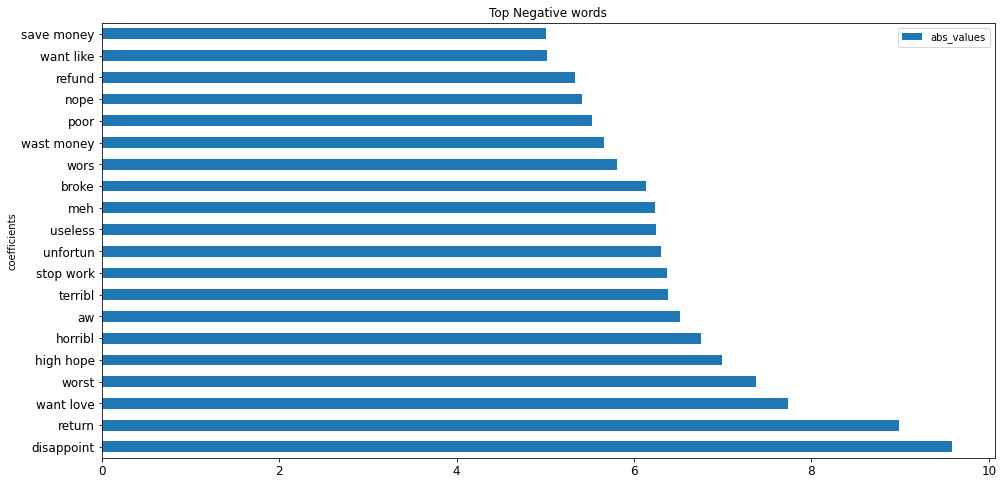

In [ ]:
coef_df.tail(20).sort_values(by='values').plot(kind = 'barh', x = 'coefficients', y = 'abs_values',
                      fontsize = 12, figsize = (16, 8), title = 'Top Negative words')
plt.savefig('gdrive/My Drive/Capstone_project/images/top_negative_words.png')

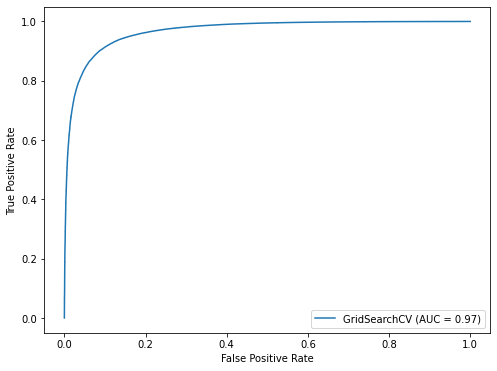

In [77]:
fig, ax = plt.subplots(figsize=(8, 6))
lr_cv = plot_roc_curve(gs, X, y, ax=ax)

In [78]:
confusion_matrix(y, pred)

array([[ 49969,  19294],
       [  7763, 351719]])

In [79]:
cm = confusion_matrix(y, pred)
cm_df = pd.DataFrame(data=cm, columns=['predicted neg', 'predicted pos'], index=['actual neg', 'actual pos'])
cm_df

,predicted neg,predicted pos
actual neg,49969,19294
actual pos,7763,351719


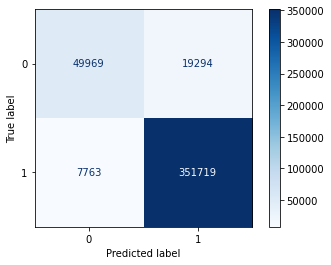

In [81]:
plot_confusion_matrix(gs_model, X, y, cmap='Blues', values_format='d');

# plt.savefig('gdrive/My Drive/Capstone_project/images/confusion_matrix.png', transparent=True)

In [82]:
tn, fp, fn, tp = confusion_matrix(y, pred).ravel()

In [83]:
df['predicted'] = pred

In [84]:
misclassified = df['Sentiment_rating']!=df['predicted']

In [85]:
pd.set_option('max_colwidth', None)
df[misclassified]

,reviewerID,ratings,title,reviewcomb,clean_text,polarity,Sentiment_rating,predicted
22,AJIKD1JKHSUD1,2.0,"Marvis Jasmin Mint Toothpaste, 3.8 oz",size is small... i did not read the title well... not great value for the price i got it for... not great value for the price i got it for,size small read titl well great valu price got great valu price got,-0.350000,0,1
31,A2BGPGEFZK12ZX,1.0,"Marvis Jasmin Mint Toothpaste, 3.8 oz",tastes like soap to me...nice after mint but had to give it away and she liked the flavor...I Will stick with other flavors!! fast ship tastes like soap to me,tast like soap nice mint give away like flavor stick flavor fast ship tast like soap,0.201563,0,1
35,A3UHFQT4E3R2D3,4.0,"Marvis Jasmin Mint Toothpaste, 3.8 oz","Unusual flavor reminds me of some herb mixed with hay. Its ok, just not as special as Id hoped. Unfortunately the old fashioned packaging and emphasis on jasmine somehow lulled me (my bad) into thinking this was a more natural toothpaste without SLS (which I have avoided for years) but unfortunately it has it, and irritates my mouth and brought me my first canker sore in many years. If you're open minded and SLS tolerant, try it. Itd be part of my rotation if it weren't for foaming agent. Interesting taste, not natural however",unusu flavor remind herb mix hay ok special id hope unfortun old fashion packag emphasi jasmin somehow lull bad think natur toothpast without sls avoid year unfortun irrit mouth brought first canker sore mani year open mind sls toler tri itd part rotat foam agent interest tast natur howev,0.083810,1,0
52,A22YTZWV58VR31,1.0,"Marvis Jasmin Mint Toothpaste, 3.8 oz","It is for women! Be careful, price is also expensive. One Star",women care price also expens one star,-0.300000,0,1
68,A17BMZG5TRRW6C,1.0,"Marvis Jasmin Mint Toothpaste, 3.8 oz",The stuff smells and tastes pretty bad to me so I don't ever use it. But the packaging is so pretty that I wanted to give it a try. Defiantly will not repurchase or recommend. The stuff smells and tastes pretty bad to me so I don't ever use it,stuff smell tast pretti bad ever use packag pretti want give tri defiant repurchas recommend stuff smell tast pretti bad ever use,-0.130000,0,1
...,...,...,...,...,...,...,...,...
464743,A3HWFSW2XGVNH7,1.0,"ORIBE The Collection Travel Set, 8 oz.","The ad says 8oz total, but it's only a little over 3oz total. 0.23oz per pack. 14 packs One Star",ad say oz total littl oz total oz per pack pack one star,-0.046875,0,1
464748,A2BP08GISO27VK,2.0,"JINsoon Nail Lacquer, Crush",Good quality but needed several coats. Not worth the price for me. Two Stars,good qualiti need sever coat worth price two star,0.183333,0,1
464766,A2J0MVDRNC5LUD,4.0,"Ducray Elution Shampoo, 6.7 fl. oz.","Personally, I can't really tell a difference from regular drugstore shampoos, but my husband (the person I bought it for) has really bad dandruff and itchy scalp, and he says it does help with that. Good. Not a miracle, but not a disappointment either.",person realli tell differ regular drugstor shampoo husband person bought realli bad dandruff itchi scalp say help good miracl disappoint either,0.100000,1,0
464780,A2MB3VWUD3ZK1O,1.0,L'Occitane Citrus Verbena Sorbet Body Cream 8.8Oz,Very thin. More like a parfum than a body cream or moisturizer. Not a moisturizer,thin like parfum bodi cream moistur moistur,-0.010000,0,1


# Conclusion

Logistic regression with TFIDF vetorizer have low False positive rates and also has got high Precision compared to other models. My lowest FPR is still 0.29 whcih I would like to reduce furthermore. Therefore I opted for BiLSTM and BERT which I will be discussing in a separate notebook. Link for [BiLSTM](https://colab.research.google.com/drive/1uyYvXm5KZwQ1AAPXC_ukx2GyuO-wClmI?usp=sharing) and [BERT](https://drive.google.com/file/d/1k9UdZ1lVY2HFJRTFWa3qCKLGK5xFaQLT/view?usp=sharing) are provided here.